In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
from tqdm import tqdm #for progress bar
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("krishujeniya/fitness-tracker-accelerometer-and-gyroscope-data")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/krishujeniya/fitness-tracker-accelerometer-and-gyroscope-data/versions/1


In [ ]:
df = pd.read_csv("01_Data_Processed.csv")
df.head()


,epoch (ms),Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Participants,Label,Category,Set
0,2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30
1,2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30
2,2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30
3,2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30
4,2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9009 entries, 0 to 9008
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   epoch (ms)       9009 non-null   object 
 1   Accelerometer_x  9009 non-null   float64
 2   Accelerometer_y  9009 non-null   float64
 3   Accelerometer_z  9009 non-null   float64
 4   Gyroscope_x      9009 non-null   float64
 5   Gyroscope_y      9009 non-null   float64
 6   Gyroscope_z      9009 non-null   float64
 7   Participants     9009 non-null   object 
 8   Label            9009 non-null   object 
 9   Category         9009 non-null   object 
 10  Set              9009 non-null   int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 774.3+ KB


In [ ]:
df = df.rename(columns={'epoch (ms)': 'timestamp'})
df.head()

,timestamp,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Participants,Label,Category,Set
0,2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30
1,2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30
2,2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30
3,2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30
4,2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30


In [ ]:
df = df.drop(columns=['Category', 'Set'])
df = df.rename(columns={'Accelerometer_x': 'X', 'Accelerometer_y': 'Y', 'Accelerometer_z': 'Z'})

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,X,Y,Z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Participants,Label
0,2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench
1,2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench
2,2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench
3,2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench
4,2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench


In [ ]:
df.shape

(9009, 9)

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Scale the raw sensor columns
scaler = StandardScaler()
df[['X', 'Y', 'Z', 'Gyroscope_x', 'Gyroscope_y', 'Gyroscope_z']] = scaler.fit_transform(df[['X', 'Y', 'Z', 'Gyroscope_x', 'Gyroscope_y', 'Gyroscope_z']])  # 'A' should probably be 'X'

# Encode labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Print label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:", label_mapping)

# Extract features and labels
X_raw = df[['X', 'Y', 'Z', 'Gyroscope_x', 'Gyroscope_y', 'Gyroscope_z']].values
Y_raw = df['Label'].values

# === OVERSAMPLING STARTS HERE ===
ros = RandomOverSampler(random_state=42)
X_resampled, Y_resampled = ros.fit_resample(X_raw, Y_raw)

print("Before oversampling:", X_raw.shape, Y_raw.shape)
print("After oversampling:", X_resampled.shape, Y_resampled.shape)

print("Dataset loaded, preprocessed, and balanced.")
X_raw = X_resampled
Y_raw = Y_resampled
# === OVERSAMPLING ENDS HERE ===

Label Encoding Mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5)}
Before oversampling: (9009, 6) (9009,)
After oversampling: (10056, 6) (10056,)
Dataset loaded, preprocessed, and balanced.


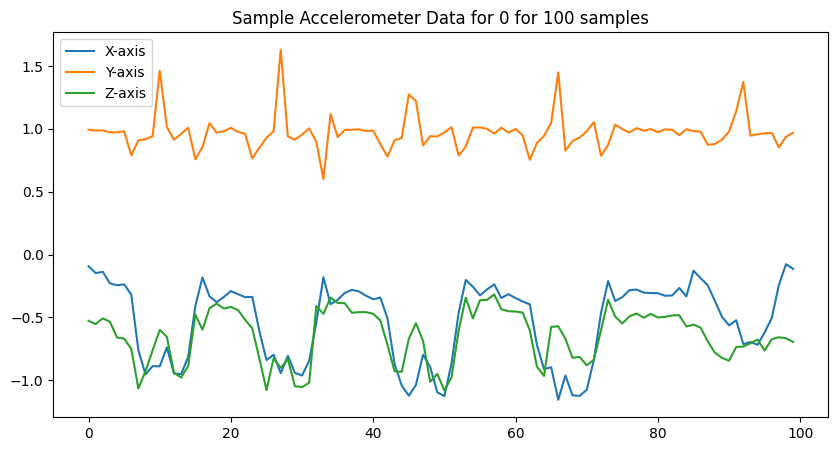

In [ ]:
# Function to plot accelerometer sample
def plot_accelerometer_sample(data, activity, n_samples=100):
    sample = data[data['Label'] == activity][['X', 'Y', 'Z']].iloc[:n_samples]
    plt.figure(figsize=(10, 5))
    plt.plot(sample['X'], label='X-axis')
    plt.plot(sample['Y'], label='Y-axis')
    plt.plot(sample['Z'], label='Z-axis')
    plt.title(f"Sample Accelerometer Data for {activity} for {n_samples} samples")
    plt.legend()
    plt.show()

# Plot a sample for one activity
plot_accelerometer_sample(df, 0)

In [ ]:

# Define parameters
num_chunks = 8
chunk_size = len(X_raw) // num_chunks
block_size = len(X_raw) // 160  # Each validation block is 20 windows
print("Chunk size:", chunk_size, "Block size:", block_size)

# Lists to store training and validation raw data
train_data = []
val_data = []
validation_indices = []  # Track validation indices for visualization

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size if i < num_chunks - 1 else len(X_raw)

    X_chunk = X_raw[start_idx:end_idx]
    Y_chunk = Y_raw[start_idx:end_idx]
    print(f"Processing chunk {i+1}/{num_chunks}")

    # Randomly select four non-overlapping validation batches
    random_starts = np.sort(np.random.choice(
        range(0, len(X_chunk) - block_size), size=4, replace=False))

    val_indices_chunk = np.concatenate([
        np.arange(start_idx + random_start, start_idx + random_start + block_size)
        for random_start in random_starts
    ])
    validation_indices.extend(val_indices_chunk)
    print(f"Selected validation indices for chunk {i+1}")

    # Store validation data
    X_val_blocks = np.concatenate([X_chunk[random_start:random_start + block_size] for random_start in random_starts])
    Y_val_blocks = np.concatenate([Y_chunk[random_start:random_start + block_size] for random_start in random_starts])

    # Define training data excluding validation blocks
    mask = np.ones(len(X_chunk), dtype=bool)
    for random_start in random_starts:
        mask[random_start:random_start + block_size] = False

    X_train_chunk = X_chunk[mask]
    Y_train_chunk = Y_chunk[mask]

    train_data.append((X_train_chunk, Y_train_chunk))
    val_data.append((X_val_blocks, Y_val_blocks))

# Combine all training and validation data
X_train = np.concatenate([data[0] for data in train_data])
Y_train = np.concatenate([data[1] for data in train_data])
X_val = np.concatenate([data[0] for data in val_data])
Y_val = np.concatenate([data[1] for data in val_data])
print("Train and validation sets created.")


Chunk size: 1257 Block size: 62
Processing chunk 1/8
Selected validation indices for chunk 1
Processing chunk 2/8
Selected validation indices for chunk 2
Processing chunk 3/8
Selected validation indices for chunk 3
Processing chunk 4/8
Selected validation indices for chunk 4
Processing chunk 5/8
Selected validation indices for chunk 5
Processing chunk 6/8
Selected validation indices for chunk 6
Processing chunk 7/8
Selected validation indices for chunk 7
Processing chunk 8/8
Selected validation indices for chunk 8
Train and validation sets created.


In [ ]:
# Sliding window function
def create_windows(X, Y, window_size):
    features, labels = [], []
    for i in range(0, len(X) - window_size, window_size // 2):
        features.append(X[i:i + window_size].T)
        labels.append(Y[i + window_size // 2])
    return np.array(features), np.array(labels)

# Apply sliding windows on train and validation sets separately
sequence_length = 150  # Define sequence length
X_train_windows, Y_train_windows = create_windows(X_train, Y_train, sequence_length)
X_val_windows, Y_val_windows = create_windows(X_val, Y_val, sequence_length)
print("Sliding windows applied.")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_windows)
Y_train_tensor = torch.LongTensor(Y_train_windows)
X_val_tensor = torch.FloatTensor(X_val_windows)
Y_val_tensor = torch.LongTensor(Y_val_windows)
print("Converted data to PyTorch tensors.")

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Changed batch size
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # Changed batch size
print("DataLoaders created.")

Sliding windows applied.
Converted data to PyTorch tensors.
DataLoaders created.


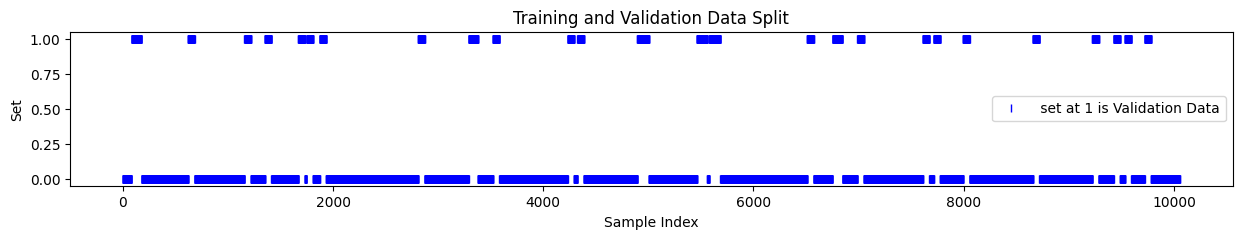

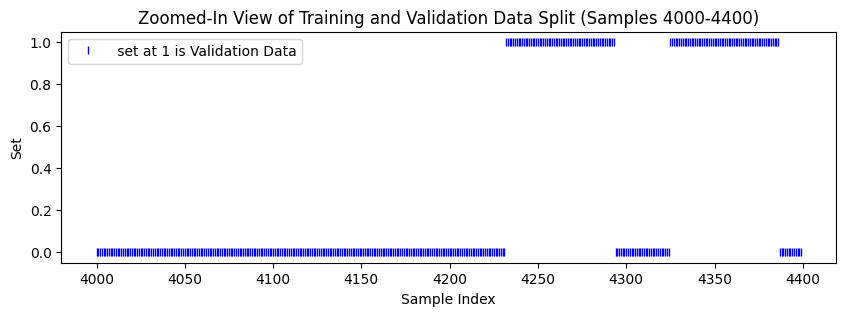

In [ ]:
# Visualization of training and validation data split
plt.figure(figsize=(15, 2))
dataset_split_visual = np.zeros(len(X_raw))
dataset_split_visual[validation_indices] = 1
plt.plot(dataset_split_visual, '|', color='blue', label=' set at 1 is Validation Data')
plt.xlabel('Sample Index')
plt.ylabel('Set')
plt.title('Training and Validation Data Split')
plt.legend()
plt.show()


# Select a specific window for closer inspection
zoom_start = 4000  # Change this to zoom in on a different range
zoom_end = 4400   # Adjust to control how much of the window is displayed

# Plot zoomed-in view
plt.figure(figsize=(10, 3))
plt.plot(range(zoom_start, zoom_end), dataset_split_visual[zoom_start:zoom_end], '|', color='blue', label=' set at 1 is Validation Data')
plt.xlabel('Sample Index')
plt.ylabel('Set')
plt.title(f'Zoomed-In View of Training and Validation Data Split (Samples {zoom_start}-{zoom_end})')
plt.legend()
plt.show()


Shapes after windowing -> X_train_windows: (108, 6, 150) Y_train_windows: (108,)
Shapes after windowing -> X_val_windows: (25, 6, 150) Y_val_windows: (25,)
Final Shapes -> X_train_windows: (108, 150, 6) X_val_windows: (25, 150, 6)


Model: "deepconv"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 30, 32)              │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 30, 32)              │          11,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 30, 32)              │          11,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 30, 32)              │          11,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         123,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,883 (683.14 KB)

 Trainable params: 174,883 (683.14 KB)

 Non-trainable params: 0 (0.00 B)

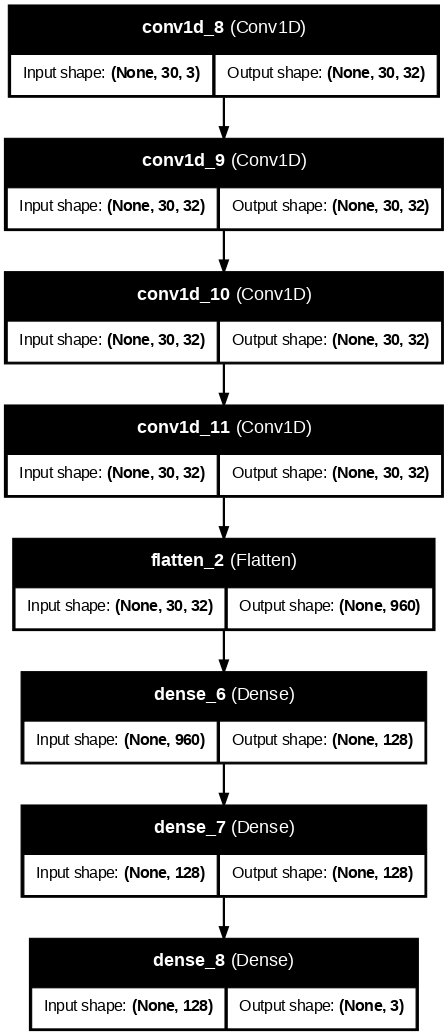

In [ ]:
print("Shapes after windowing -> X_train_windows:", X_train_windows.shape, "Y_train_windows:", Y_train_windows.shape)
print("Shapes after windowing -> X_val_windows:", X_val_windows.shape, "Y_val_windows:", Y_val_windows.shape)


# Reshape for Conv1D (batch_size, timesteps, channels)
X_train_windows_transposed = np.transpose(X_train_windows, (0, 2, 1))  # (num_samples, timesteps, channels)
X_val_windows_transposed = np.transpose(X_val_windows, (0, 2, 1))      # (num_samples, timesteps, channels)

# Print final shapes before training
print("Final Shapes -> X_train_windows:", X_train_windows_transposed.shape, "X_val_windows:", X_val_windows_transposed.shape)



# Function to build your CNN model
def build_conv1D_model(n_timesteps, n_channels, n_classes):
    model = keras.Sequential(name="deepconv")
    model.add(keras.layers.Input(shape=(n_timesteps, n_channels)))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=11, activation='relu', padding="same"))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=11, activation='relu', padding="same"))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=11, activation='relu', padding="same"))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=11, activation='relu', padding="same"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(n_classes, activation='softmax'))
    model.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and summarize the model
model_conv1D = build_conv1D_model(30, 3, 3)  # Example: 30 timesteps, 3 channels (X, Y, Z), 3 classes
model_conv1D.summary()

from tensorflow.keras.utils import plot_model

# Visualize the model
plot_model(
    model_conv1D,
    show_shapes=True,
    show_layer_names=True,
    dpi=80
)

In [ ]:
# Train Conv1D model
n_timesteps, n_channels = X_train_windows_transposed.shape[1], X_train_windows_transposed.shape[2]
n_classes = len(np.unique(Y_train_windows))
model_conv1D = build_conv1D_model(n_timesteps, n_channels, n_classes)
model_conv1D.fit(X_train_windows_transposed, Y_train_windows, epochs=25, batch_size=32, verbose=1, validation_data=(X_val_windows_transposed, Y_val_windows))

# Evaluate Conv1D model
y_pred = np.argmax(model_conv1D.predict(X_val_windows_transposed), axis=1)
f1 = f1_score(Y_val_windows, y_pred, average='weighted')
print(f"Conv1D Model F1 Score: {f1}")

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.1898 - loss: 1.8054 - val_accuracy: 0.3600 - val_loss: 1.7392
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.2705 - loss: 1.7552 - val_accuracy: 0.2800 - val_loss: 1.7048
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2987 - loss: 1.7162 - val_accuracy: 0.3200 - val_loss: 1.6653
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2605 - loss: 1.6688 - val_accuracy: 0.3600 - val_loss: 1.6023
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3323 - loss: 1.6163 - val_accuracy: 0.4000 - val_loss: 1.5583
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.3031 - loss: 1.5476 - val_accuracy: 0.4000 - val_loss: 1.5007
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4301 - loss: 1.5050 - val_accuracy: 0.4000 - val_loss: 1.4428
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.3493 - loss: 1.4317 - val_accuracy: 0.4000 - val_loss: 1.2605

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Conv1D Model F1 Score: 0.7464848484848484


In [ ]:
# model from - https://github.com/mariusbock/dl-for-har/tree/main/tutorial_notebooks
import torch
from torch import nn

class DeepConvLSTM(nn.Module):
    def __init__(self, config):
        super(DeepConvLSTM, self).__init__()
        self.window_size = config['window_size']
        self.nb_channels = config['nb_channels']
        self.nb_classes = config['nb_classes']
        self.nb_filters = config['nb_filters']
        self.filter_width = min(config['filter_width'], self.window_size)  # Ensure valid kernel size
        self.nb_units_lstm = config['nb_units_lstm']
        self.nb_layers_lstm = config['nb_layers_lstm']
        self.drop_prob = config['drop_prob']

        # Define layers
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(1, self.nb_filters, (self.filter_width, 1), padding=(self.filter_width // 2, 0))
        self.conv2 = nn.Conv2d(self.nb_filters, self.nb_filters, (self.filter_width, 1), padding=(self.filter_width // 2, 0))
        self.conv3 = nn.Conv2d(self.nb_filters, self.nb_filters, (self.filter_width, 1), padding=(self.filter_width // 2, 0))
        self.conv4 = nn.Conv2d(self.nb_filters, self.nb_filters, (self.filter_width, 1), padding=(self.filter_width // 2, 0))

        # LSTM layer
        self.lstm = nn.LSTM(input_size=self.nb_filters * self.nb_channels, hidden_size=self.nb_units_lstm,
                            num_layers=self.nb_layers_lstm, batch_first=True)

        self.dropout = nn.Dropout(self.drop_prob)
        self.fc = nn.Linear(self.nb_units_lstm, self.nb_classes)

    def forward(self, x):
        # Reshape for convolutional layers
        x = x.view(-1, 1, self.window_size, self.nb_channels)  # (batch_size, 1, window_size, nb_channels)

        # Apply convolutional layers with ReLU activation
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))

        # Reshape for LSTM layers
        x = x.permute(0, 2, 1, 3).reshape(-1, x.shape[2], self.nb_filters * self.nb_channels)

        # Apply LSTM
        x, _ = self.lstm(x)

        # Apply dropout and classifier
        x = self.dropout(x[:, -1, :])  # Take only the last output of the LSTM
        x = self.fc(x)
        return x


In [ ]:
##Step 1: Model Initialization
# Define DeepConvLSTM Configuration
config = {
    'window_size': X_train_windows.shape[1],  # Sequence length
    'nb_channels': X_train_windows.shape[2],  # Number of sensor channels (X, Y, Z)
    'nb_classes': len(np.unique(Y_train_windows)),  # Number of activity classes
    'nb_filters': 64,  # Number of Conv filters
    'filter_width': 5,  # Kernel size
    'nb_units_lstm': 128,  # LSTM hidden units
    'nb_layers_lstm': 2,  # LSTM layers
    'drop_prob': 0.5  # Dropout probability
}

# Initialize model
model_lstm = DeepConvLSTM(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lstm.to(device)

## Step 2: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-4)


## Step 3: Model Training Loop
# Train DeepConvLSTM
num_epochs = 10

for epoch in range(num_epochs):
    model_lstm.train()
    running_loss = 0.0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        outputs = model_lstm(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1} training loss: {epoch_loss:.4f}")


    # Validation
    model_lstm.eval()
    val_loss = 0
    val_accuracy = 0
    epoch_true_labels, epoch_predicted_labels = [], []

    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            outputs = model_lstm(batch_X)
            loss = criterion(outputs, batch_Y)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == batch_Y).sum().item()
            epoch_predicted_labels.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(batch_Y.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy /= len(val_dataset)
    f1 = f1_score(epoch_true_labels, epoch_predicted_labels, average='weighted')

    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, F1 Score: {f1:.4f}')

# Evaluate DeepConvLSTM model
y_pred = []
y_true = []


##Step 4: Validation (After Each Epoch)
model_lstm.eval()
with torch.no_grad():
    for batch_X, batch_Y in val_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        outputs = model_lstm(batch_X)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(batch_Y.cpu().numpy())

# Compute final F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"DeepConvLSTM Model F1 Score: {f1}")


Epoch 1 training loss: 1.8018
Epoch 1/10, Validation Loss: 1.7826, Validation Accuracy: 0.1600, F1 Score: 0.0971
Epoch 2 training loss: 1.7895
Epoch 2/10, Validation Loss: 1.7825, Validation Accuracy: 0.2800, F1 Score: 0.1971
Epoch 3 training loss: 1.7879
Epoch 3/10, Validation Loss: 1.7859, Validation Accuracy: 0.3200, F1 Score: 0.2140
Epoch 4 training loss: 1.7756
Epoch 4/10, Validation Loss: 1.7912, Validation Accuracy: 0.1200, F1 Score: 0.0424
Epoch 5 training loss: 1.7722
Epoch 5/10, Validation Loss: 1.7978, Validation Accuracy: 0.1200, F1 Score: 0.0400
Epoch 6 training loss: 1.7603
Epoch 6/10, Validation Loss: 1.8058, Validation Accuracy: 0.1200, F1 Score: 0.0257
Epoch 7 training loss: 1.7667
Epoch 7/10, Validation Loss: 1.8122, Validation Accuracy: 0.1200, F1 Score: 0.0277
Epoch 8 training loss: 1.7386
Epoch 8/10, Validation Loss: 1.7956, Validation Accuracy: 0.1200, F1 Score: 0.0257
Epoch 9 training loss: 1.7228
Epoch 9/10, Validation Loss: 1.7772, Validation Accuracy: 0.1200, 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Dictionary to store F1 scores for each model
f1_scores = {}

# Conv1D CNN Predictions
cnn_y_pred = np.argmax(model_conv1D.predict(X_val_windows_transposed), axis=1)
cnn_f1 = f1_score(Y_val_windows, cnn_y_pred, average='weighted')
f1_scores["Conv1D CNN"] = cnn_f1




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


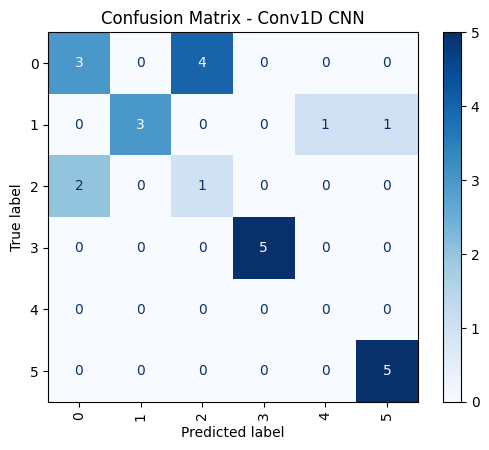

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    # Dynamically extract the unique labels present in the dataset
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot for each model
plot_confusion_matrix(Y_val_windows, cnn_y_pred, "Conv1D CNN")

